# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [1]:
from __future__ import division, print_function
%matplotlib inline
# from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
# from theano.sandbox import cuda - deprecate in Theano 0.9

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


In [2]:
# SETUP DIRS
root_dir = os.getcwd()
print(root_dir)
%mkdir -p data/fish/train
%mkdir -p data/fish/valid
%cd data/fish/train
# %cd ../../..

/home/ubuntu/git/courses/deeplearning1/nbs
/home/ubuntu/git/courses/deeplearning1/nbs/data/fish/train


In [3]:
g = glob('*')
for d in g: 
    directory = '../valid/'+d
    if not os.path.exists(directory):
        os.makedirs(directory)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [4]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [5]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [6]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ubuntu/git/courses/deeplearning1/nbs/data/fish/valid
/home/ubuntu/git/courses/deeplearning1/nbs/data/fish


In [2]:
%mkdir results
%mkdir sample/results
%cd ../..

mkdir: cannot create directory ‘sample/results’: No such file or directory
/home/ubuntu/git/courses


In [4]:
%pwd
# %cd /home/ubuntu/git/courses/deeplearning1/nbs/

/home/ubuntu/git/courses/deeplearning1/nbs


In [5]:
#path = "data/fish/sample/"
path = "data/fish/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)


In [6]:
#batch_size=64
batch_size=4
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [7]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [8]:
print(test_filenames[0], filenames[0], val_filenames[0])


test_stg1/img_00005.jpg ALB/img_00003.jpg ALB/img_00032.jpg


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [9]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)  # Resnet with model size = 2500MB in memory using Theano

In [38]:
trn = get_data(path+'train') # these lines run quite slow on p2
val = get_data(path+'valid')
print(trn.shape, val.shape)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
(3277, 3, 224, 224) (500, 3, 224, 224)


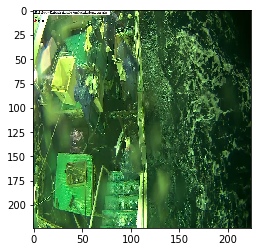

In [21]:
plot(val[0])
plot(val[1])
plot(val[2])
#     plt.gca().add_patch(create_rect(bb))

In [138]:
??get_data

In [39]:
print(path)
test = get_data(path+'test')

data/fish/
Found 1000 images belonging to 1 classes.


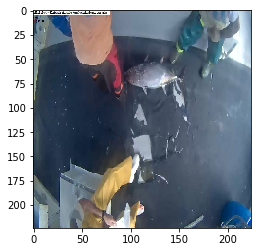

In [36]:
plot(test[4])

In [151]:
# save_array(path+'results/trn.dat', trn)
# save_array(path+'results/val.dat', val)

In [23]:
# save_array(path+'results/test.dat', test)

In [10]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [11]:
test = load_array(path+'results/test.dat')

In [12]:
gen = image.ImageDataGenerator()

In [10]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# model.optimizer.lr = 0.0001
model.fit(trn, trn_labels,   # this model is quite prone to overfitting
          batch_size=batch_size, 
#           batch_size=64,
          nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 75s 23ms/step - loss: 2.7176 - acc: 0.7391 - val_loss: 3.6392 - val_acc: 0.6980
Epoch 2/3
3277/3277 [==============================] - 75s 23ms/step - loss: 2.6299 - acc: 0.7580 - val_loss: 3.7263 - val_acc: 0.6940
Epoch 3/3
1024/3277 [========>.....................] - ETA: 44s - loss: 2.3138 - acc: 0.7842

KeyboardInterrupt: 

In [28]:
# model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [13]:
model.load_weights(path+'results/ft1.h5')

In [14]:
model.evaluate(val, val_labels) # do one test on the validation set

500/500 [==============================] - 11s 23ms/step


[4.1099078899025914, 0.66400000095367429]

In [30]:
??split_at

In [15]:
# separate out the conv and the FC layers
conv_layers, fc_layers = split_at(model, Convolution2D)
print(len(conv_layers), len(fc_layers))

31 9


In [16]:
# build a model with just the conv layers, with all the weights loaded
conv_model = Sequential(conv_layers)

In [17]:
# conv_feat = conv_model.predict(trn)
# conv_val_feat = conv_model.predict(val)

In [18]:
# conv_test_feat = conv_model.predict(test)

In [19]:
# save_array(path+'results/conv_val_feat.dat', conv_val_feat)
# save_array(path+'results/conv_feat.dat', conv_feat)

In [20]:
# save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [21]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [22]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [23]:
conv_val_feat.shape

(500, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.
We stack them on top of the conv layers.


In [24]:
print(conv_layers[-1].output_shape[1:]) #(512, 14, 14)
def get_bn_layers(p):
    return [
        # maxx pooling needs to know the input shape
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4.0),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2.0),
        Dense(8, activation='softmax')
    ]

(512, 14, 14)


In [25]:
p=0.6

In [26]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 7s 2ms/step - loss: 0.6332 - acc: 0.7952 - val_loss: 0.2687 - val_acc: 0.9320
Epoch 2/3
3277/3277 [==============================] - 7s 2ms/step - loss: 0.5492 - acc: 0.8151 - val_loss: 0.3353 - val_acc: 0.9180
Epoch 3/3
3277/3277 [==============================] - 7s 2ms/step - loss: 0.5209 - acc: 0.8316 - val_loss: 0.3303 - val_acc: 0.9020


In [75]:
bn_model.optimizer.lr = 1e-4

In [76]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.4675 - acc: 0.8416 - val_loss: 0.2073 - val_acc: 0.9400
Epoch 2/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.4163 - acc: 0.8630 - val_loss: 0.2045 - val_acc: 0.9520
Epoch 3/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.4349 - acc: 0.8575 - val_loss: 0.2097 - val_acc: 0.9400
Epoch 4/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3907 - acc: 0.8727 - val_loss: 0.2158 - val_acc: 0.9400
Epoch 5/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3594 - acc: 0.8904 - val_loss: 0.2112 - val_acc: 0.9540
Epoch 6/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3830 - acc: 0.8752 - val_loss: 0.1828 - val_acc: 0.9540
Epoch 7/7
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3628 - acc: 0.8795 - val_loss: 0.1868 - val_acc: 0.9600


In [77]:
# bn_model.save_weights(path+'models/conv_512_6.h5')

In [27]:
bn_model.load_weights(path+'models/conv_512_6.h5')

In [28]:
bn_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 0s 206us/step


[0.18677916705608369, 0.95999999952316284]

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [29]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [30]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 171,
         (1244, 700): 26,
         (1276, 718): 188,
         (1280, 720): 1884,
         (1280, 750): 521,
         (1280, 924): 52,
         (1280, 974): 344,
         (1334, 750): 26,
         (1518, 854): 35,
         (1732, 974): 30})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [31]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [32]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [33]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

print(trn_sizes.shape, val_sizes.shape)

(3277, 10) (500, 10)


To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [34]:
p=0.6

In [35]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

# I faced exploding gradients, so I used tanh instead of relu
# and varies the batch size. One key take-away is that training 
# fully-connected layers are quite hard and prone to overfit/exploding
# symptom is loss -> nan
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4.0)(x)
x = Flatten()(x)
x = Dense(512, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(p/2.0)(x)
x = merge([x, bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


When we compile the model, we have to specify all the input layers in an array.

In [36]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [136]:
model.fit([conv_feat, trn_sizes], trn_labels, 
          batch_size=16, 
          nb_epoch=3, 
          validation_data=([conv_val_feat, val_sizes], val_labels))

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s 740us/step - loss: 1.3873 - acc: 0.5838 - val_loss: 0.3913 - val_acc: 0.8980
Epoch 2/3
3277/3277 [==============================] - 2s 704us/step - loss: 0.5052 - acc: 0.8505 - val_loss: 0.2607 - val_acc: 0.9260
Epoch 3/3
3277/3277 [==============================] - 2s 704us/step - loss: 0.3272 - acc: 0.9103 - val_loss: 0.2260 - val_acc: 0.9380


In [138]:
model.optimizer.lr = 0.00001
model.fit([conv_feat, trn_sizes], trn_labels, 
          batch_size=16, 
          nb_epoch=3, 
          validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
 208/3277 [>.............................] - ETA: 2s - loss: 0.0953 - acc: 0.9760

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


3277/3277 [==============================] - 2s 744us/step - loss: 0.1210 - acc: 0.9661 - val_loss: 0.1636 - val_acc: 0.9680
Epoch 2/3
3277/3277 [==============================] - 2s 703us/step - loss: 0.1212 - acc: 0.9646 - val_loss: 0.1776 - val_acc: 0.9640
Epoch 3/3
3277/3277 [==============================] - 2s 704us/step - loss: 0.1056 - acc: 0.9698 - val_loss: 0.1783 - val_acc: 0.9740


In [98]:
# now compare to the model without the leakage
bn_model.optimizer.lr = 1e-4

In [99]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3401 - acc: 0.8908 - val_loss: 0.2070 - val_acc: 0.9580
Epoch 2/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3100 - acc: 0.8999 - val_loss: 0.2273 - val_acc: 0.9520
Epoch 3/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.3167 - acc: 0.8972 - val_loss: 0.1834 - val_acc: 0.9580
Epoch 4/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.2559 - acc: 0.9124 - val_loss: 0.2150 - val_acc: 0.9480
Epoch 5/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.2845 - acc: 0.9130 - val_loss: 0.1810 - val_acc: 0.9640
Epoch 6/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.2503 - acc: 0.9149 - val_loss: 0.1942 - val_acc: 0.9620
Epoch 7/8
3277/3277 [==============================] - 7s 2ms/step - loss: 0.2454 - acc: 0.9170 - val_loss: 0.1939 - val_acc: 0.9600
Epoch 8/8
3277/3277 [=

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

Interestingly, pay attention to the val_acc and val_loss in both cases, they jump around quite a bit - which is not a great sign!

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [37]:
import ujson as json

In [38]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [39]:
def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
    
    for url_suffix, md5_hash in annot_urls.iteritems():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir=cache_subdir, md5_hash=md5_hash)

In [40]:
get_annotations()

In [41]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [42]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [43]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [44]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [45]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [46]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [47]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [48]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

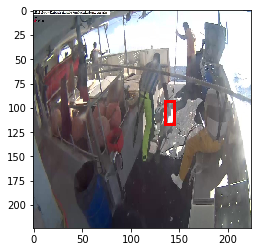

In [49]:
show_bb(101)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [50]:
p=0.6  # drop out ratio

In [51]:
# so this is how we get
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
# notice how x_bb and x_class are parallel and both take x as input
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [52]:
# ??Model -> this comes from Keras

In [53]:
# you put the two output layer in parallel
model = Model([inp], [x_bb, x_class])

# notice how the loss functions uses two losses, one for the box and
# one for the class - with the weights to average/combine them
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],
              loss_weights=[.001, 1.])

In [156]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, 
          nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 8s 2ms/step - loss: 5.4964 - bb_loss: 3865.8490 - class_loss: 1.6306 - bb_acc: 0.4461 - class_acc: 0.4998 - val_loss: 2.9983 - val_bb_loss: 2311.0420 - val_class_loss: 0.6873 - val_bb_acc: 0.5520 - val_class_acc: 0.7860
Epoch 2/3
3277/3277 [==============================] - 8s 2ms/step - loss: 2.3863 - bb_loss: 1408.3052 - class_loss: 0.9780 - bb_acc: 0.5346 - class_acc: 0.6811 - val_loss: 1.2417 - val_bb_loss: 796.4221 - val_class_loss: 0.4453 - val_bb_acc: 0.6000 - val_class_acc: 0.8780
Epoch 3/3
3277/3277 [==============================] - 8s 2ms/step - loss: 1.7852 - bb_loss: 984.7599 - class_loss: 0.8004 - bb_acc: 0.5532 - class_acc: 0.7385 - val_loss: 1.0495 - val_bb_loss: 649.9611 - val_class_loss: 0.3995 - val_bb_acc: 0.5660 - val_class_acc: 0.8960


In [109]:
model.optimizer.lr = 1e-5

In [110]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
  64/3277 [..............................] - ETA: 9s - loss: 0.7985 - bb_loss: 570.0873 - class_loss: 0.2284 - bb_acc: 0.5156 - class_acc: 0.9219

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


3277/3277 [==============================] - 8s 2ms/step - loss: 0.8379 - bb_loss: 648.4660 - class_loss: 0.1895 - bb_acc: 0.5984 - class_acc: 0.9332 - val_loss: 0.5299 - val_bb_loss: 347.2208 - val_class_loss: 0.1827 - val_bb_acc: 0.6800 - val_class_acc: 0.9680
Epoch 2/10
3277/3277 [==============================] - 8s 2ms/step - loss: 0.8946 - bb_loss: 656.5547 - class_loss: 0.2381 - bb_acc: 0.6082 - class_acc: 0.9298 - val_loss: 0.5481 - val_bb_loss: 369.6335 - val_class_loss: 0.1785 - val_bb_acc: 0.6840 - val_class_acc: 0.9720
Epoch 3/10
3277/3277 [==============================] - 8s 2ms/step - loss: 0.8703 - bb_loss: 651.2503 - class_loss: 0.2190 - bb_acc: 0.6112 - class_acc: 0.9347 - val_loss: 0.5388 - val_bb_loss: 344.0922 - val_class_loss: 0.1948 - val_bb_acc: 0.6880 - val_class_acc: 0.9680
Epoch 4/10
3277/3277 [==============================] - 8s 2ms/step - loss: 0.8617 - bb_loss: 649.1367 - class_loss: 0.2126 - bb_acc: 0.6094 - class_acc: 0.9335 - val_loss: 0.5514 - val_bb_

Excitingly, it turned out that the classification model is much improved by giving it this additional task. 

Even if we just throw the bounding box away, it helps to notify the classifier where is the fish. Empirical evidence is that the model is much more resilient, accurate and stable classification.

Let's see how well the bounding box model did by taking a look at its output.

In [162]:
pred = model.predict(conv_val_feat[0:10])

In [163]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

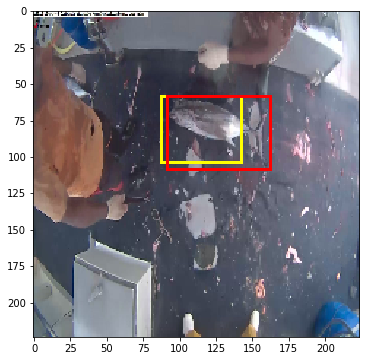

In [167]:
show_bb_pred(5)

In [172]:
eval_metrics = model.evaluate(conv_val_feat, [val_bbox, val_labels])

print( '[loss, bb_loss, classification_loss, bb_acc, classification_acc]', 
       '\n' , kk)

# what are the output?
# [loss, bb_loss, classification_loss, bb_acc, classification_acc]
# because we predict 2 things now!

500/500 [==============================] - 0s 247us/step
[loss, bb_loss, classification_loss, bb_acc, classification_acc] 
 [0.5326514546871185, 333.26582409667969, 0.1993856134414673, 0.6899999990463257, 0.95799999952316284]


In [115]:
# model.save_weights(path+'models/bn_anno.h5')

In [157]:
model.load_weights(path+'models/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [270]:
# get data must help us do resizing here
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


The image shows that things are much clearer at this size.

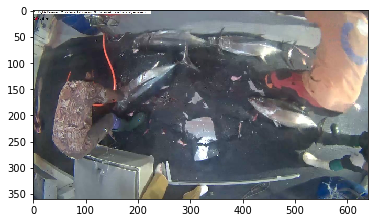

In [207]:
plot(trn[0])

In [271]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [272]:
# save_array(path+'results/trn_640.dat', trn)
# save_array(path+'results/val_640.dat', val)

In [273]:
# save_array(path+'results/test_640.dat', test)

In [54]:
trn = load_array(path+'results/trn_640.dat') # these are quite large arrays
val = load_array(path+'results/val_640.dat')


In [55]:
print( trn.shape, val.shape)

(3277, 3, 360, 640) (500, 3, 360, 640)


We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [56]:
vgg640 = Vgg16BN((360, 640)).model  # image is cols by rows - be careful!
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.

In [57]:
# conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
# conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

In [58]:
# save_array(path+'results/conv_val_640.dat', conv_val_feat)
# save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [59]:
# conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

In [60]:
# save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [61]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [62]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

In [63]:
print(conv_val_feat.shape, conv_trn_feat.shape, conv_test_feat.shape)

(500, 512, 22, 40) (3277, 512, 22, 40) (1000, 512, 22, 40)


In [64]:
for i in range(conv_trn_feat.shape[0]):
    sample = conv_trn_feat[i]
#     print(i, np.max(sample), np.min(sample))

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [65]:
conv_layers, _ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [66]:
# nf=128; p=0.2
nf=128; p=0.1

In [67]:
# You need relu layers here, otherwise the heatmap doesn't work with tanh
# layers
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, activation='relu', border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [68]:
lrg_model = Sequential(get_lrg_layers())

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  if sys.path[0] == '':
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
  from ipykernel import kernelapp as app


In [69]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 11, 20)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 11, 20)       147584    
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 11, 20)       512       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 5, 10)        0         
__________

In [396]:
lrg_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [397]:
# lrg_model.optimizer.lr=0.001

In [398]:
# be careful here - we need a large-enough batch size to compete 
lrg_model.fit(conv_trn_feat, trn_labels, 
              batch_size=32, 
              nb_epoch=4, 
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/4
3277/3277 [==============================] - 11s 3ms/step - loss: 1.2548 - acc: 0.5838 - val_loss: nan - val_acc: 0.6640
Epoch 2/4
3277/3277 [==============================] - 11s 3ms/step - loss: 0.6874 - acc: 0.8334 - val_loss: nan - val_acc: 0.8640
Epoch 3/4
3277/3277 [==============================] - 11s 3ms/step - loss: 0.4182 - acc: 0.9304 - val_loss: nan - val_acc: 0.9260
Epoch 4/4
3277/3277 [==============================] - 11s 3ms/step - loss: 0.2755 - acc: 0.9689 - val_loss: 2.0075 - val_acc: 0.9440


In [297]:
for i in range(conv_trn_feat.shape[0]):
    sample = conv_trn_feat[i]
#     print(i, np.max(sample), np.min(sample))

In [399]:
lrg_model.optimizer.lr=1e-6

In [400]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=32, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.1914 - acc: 0.9866 - val_loss: 2.0047 - val_acc: 0.9460
Epoch 2/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.1424 - acc: 0.9942 - val_loss: 1.9993 - val_acc: 0.9520
Epoch 3/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.1131 - acc: 0.9963 - val_loss: 2.0150 - val_acc: 0.9560
Epoch 4/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0907 - acc: 0.9979 - val_loss: 2.0005 - val_acc: 0.9620
Epoch 5/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0756 - acc: 0.9985 - val_loss: 2.0048 - val_acc: 0.9620
Epoch 6/6
3277/3277 [==============================] - 11s 3ms/step - loss: 0.0657 - acc: 0.9988 - val_loss: 2.0082 - val_acc: 0.9740


When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [401]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [402]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [403]:
lrg_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 1s 2ms/step


[2.016618399620056, 0.97399999952316285]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [404]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [405]:
def get_cm(inp, label):
    """Get the convolutional heatmap"""
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [406]:
conv_val_feat[1].shape

(512, 22, 40)

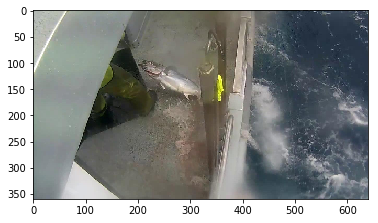

In [407]:
sample_id = 10
plt.imshow(to_plot(val[sample_id]))

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [410]:
inp = conv_val_feat[sample_id:sample_id+1]
print(inp.shape, conv_val_feat.shape)
# print(inp)
print(np.sum(lrg_model.predict(conv_val_feat)[sample_id]))
np.round(lrg_model.predict(conv_val_feat)[sample_id],2)

(1, 512, 22, 40) (500, 512, 22, 40)
1.0


array([ 0.12,  0.12,  0.12,  0.12,  0.12,  0.12,  0.12,  0.12], dtype=float32)

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


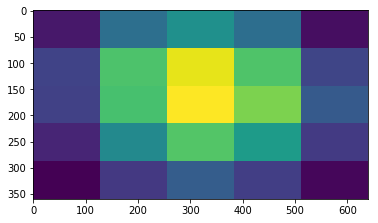

In [413]:
# debug the conv_fn and conv layer heatmap
val_labels[sample_id]
conv = conv_fn([inp,0])[0,0]
img = scipy.misc.imresize(conv, (360,640), interp='nearest')
plt.imshow(img)
# conv = conv_fn([inp,0])[0, label]
# return scipy.misc.imresize(conv, (360,640), interp='nearest')


In [414]:
cm = get_cm(inp, 0)

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


The heatmap shows that (at very low resolution) the model is finding the fish!

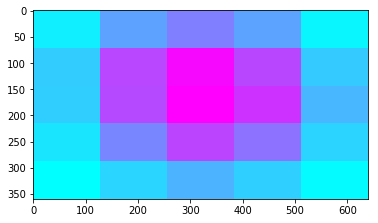

In [415]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [70]:
# you need the last layer to be relu for the heatmap to work
# remove the maxpooling layers
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='tanh', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='tanh', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='tanh', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, activation='relu', border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [71]:
# Collect memory after delete big model
import gc
# del model
# del lrg_model
# del bn_model
# del vgg640
# del conv_fn

from keras import backend as be
# be.theano_backebe.clear_session()

for i in range(10): gc.collect()


In [72]:
lrg_model = Sequential(get_lrg_layers())

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="tanh")`
  
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="tanh")`
  
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="tanh")`
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
  if sys.path[0] == '':


In [73]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 22, 40)       512       
__________

In [74]:
lrg_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [77]:
lrg_model.fit(conv_trn_feat, trn_labels, 
              batch_size=4, 
              nb_epoch=6, 
              validation_data=(conv_val_feat, val_labels))
# should be able to get to 91% here

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.7399 - acc: 0.8206 - val_loss: 4.0739 - val_acc: 0.8700
Epoch 2/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.7164 - acc: 0.8340 - val_loss: 4.1783 - val_acc: 0.8640
Epoch 3/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.6928 - acc: 0.8483 - val_loss: 4.0225 - val_acc: 0.8780
Epoch 4/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.6616 - acc: 0.8581 - val_loss: 4.1099 - val_acc: 0.8720
Epoch 5/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.6552 - acc: 0.8608 - val_loss: 3.9416 - val_acc: 0.8920
Epoch 6/6
3277/3277 [==============================] - 18s 6ms/step - loss: 0.6198 - acc: 0.8767 - val_loss: 3.8753 - val_acc: 0.8960


In [78]:
lrg_model.optimizer.lr=1e-5

In [80]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, 
              nb_epoch=20, 
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5403 - acc: 0.9036 - val_loss: 3.7528 - val_acc: 0.9160
Epoch 2/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5442 - acc: 0.9008 - val_loss: 3.6643 - val_acc: 0.9200
Epoch 3/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5381 - acc: 0.9027 - val_loss: 3.6414 - val_acc: 0.9200
Epoch 4/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5263 - acc: 0.9124 - val_loss: 3.7537 - val_acc: 0.9160
Epoch 5/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5209 - acc: 0.9121 - val_loss: 3.5763 - val_acc: 0.9280
Epoch 6/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5093 - acc: 0.9121 - val_loss: 3.6177 - val_acc: 0.9260
Epoch 7/20
3277/3277 [==============================] - 18s 6ms/step - loss: 0.5093 - acc: 0.9170 - val_loss: 3.6729 - val_acc: 0.9240
Epoch 8/

In [107]:
lrg_model.optimizer.lr=1e-6

In [108]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, 
              nb_epoch=4, 
              validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/4
3277/3277 [==============================] - 18s 5ms/step - loss: 0.4753 - acc: 0.9326 - val_loss: 3.5353 - val_acc: 0.9340
Epoch 2/4
3277/3277 [==============================] - 18s 5ms/step - loss: 0.4752 - acc: 0.9265 - val_loss: 3.5762 - val_acc: 0.9320
Epoch 3/4
3277/3277 [==============================] - 18s 6ms/step - loss: 0.4747 - acc: 0.9283 - val_loss: 3.6695 - val_acc: 0.9220
Epoch 4/4
3277/3277 [==============================] - 18s 6ms/step - loss: 0.4774 - acc: 0.9316 - val_loss: 3.6705 - val_acc: 0.9240


In [81]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [82]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [109]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [110]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [111]:
sample_idx = 10
inp = np.expand_dims(conv_val_feat[sample_idx], 0)

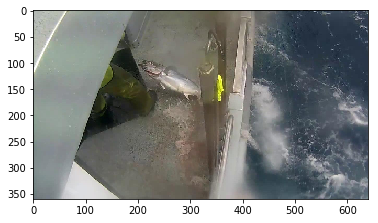

In [112]:
plt.imshow(to_plot(val[sample_idx]))

In [113]:
cm = get_cm2(inp, 0)

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
cm = get_cm2(inp, 0)  # this input maped to class 0

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


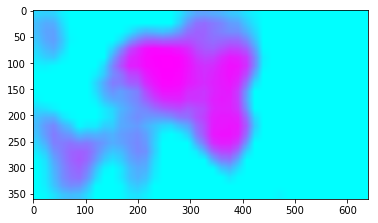

In [115]:
plt.imshow(cm, cmap="cool")

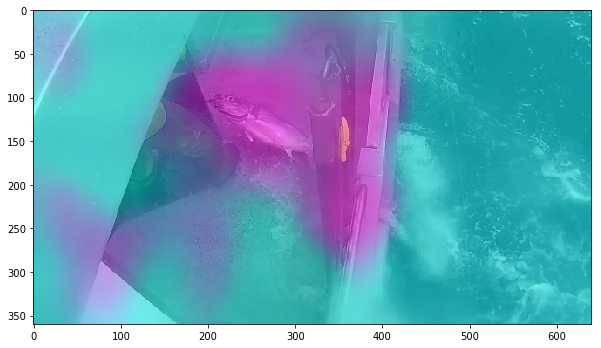

In [116]:
plt.figure(figsize=(10,10))
plot(val[10])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [106]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [107]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [108]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), padding="same", strides=(2, 2), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), padding="same", strides=(1, 1), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same", strides=(2, 2), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda2/envs/py27_tf_cv/lib/python2.7/site-packages/ipykernel_launcher

In [272]:
lrg_model = Model([inp], outp)

In [273]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.3251 - acc: 0.5536 - val_loss: 1.4769 - val_acc: 0.5080
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.4601 - acc: 0.8691 - val_loss: 0.9860 - val_acc: 0.7460


In [275]:
lrg_model.optimizer.lr=1e-5

In [277]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0260 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9480
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0240 - acc: 0.9957 - val_loss: 0.3007 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0120 - acc: 0.9976 - val_loss: 0.2506 - val_acc: 0.9500
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.2389 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.9580
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.2116 - val_acc: 0.9580


In [262]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1610 - val_acc: 0.9540
Epoch 2/10
3277/3277 [==============================] - 6s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9540
Epoch 3/10
3277/3277 [==============================] - 6s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.4845 - val_acc: 0.8760
Epoch 4/10
3277/3277 [==============================] - 6s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 5/10
3277/3277 [==============================] - 6s - loss: 0.0634 - acc: 0.9780 - val_loss: 0.2923 - val_acc: 0.9340
Epoch 6/10
3277/3277 [==============================] - 6s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.2316 - val_acc: 0.9500
Epoch 7/10
3277/3277 [==============================] - 6s - loss: 0.0049 - acc: 0.9997 - val_loss: 0.2048 - val_acc: 0.9660
Epoch 8/10
3277/3277 [==============================] - 6s - loss: 0.0016 - ac

In [110]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [153]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [210]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

In [212]:
gen = image.ImageDataGenerator()

In [214]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [215]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [217]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [292]:
mi = MixIterator([batches, test_batches, val_batches])

In [220]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
4833/4777 [==============================] - 4s - loss: 0.2538 - acc: 0.9462 - val_loss: 0.1313 - val_acc: 0.9700
Epoch 2/8
 192/4777 [>.............................] - ETA: 2s - loss: 0.1972 - acc: 0.9635

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1494: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4833/4777 [==============================] - 4s - loss: 0.2231 - acc: 0.9491 - val_loss: 0.0820 - val_acc: 0.9820
Epoch 3/8
4833/4777 [==============================] - 3s - loss: 0.1860 - acc: 0.9545 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/8
4833/4777 [==============================] - 3s - loss: 0.1559 - acc: 0.9663 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 5/8
4825/4777 [==============================] - 3s - loss: 0.1366 - acc: 0.9693 - val_loss: 0.0422 - val_acc: 0.9840
Epoch 6/8
4833/4777 [==============================] - 3s - loss: 0.1303 - acc: 0.9704 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 7/8
4833/4777 [==============================] - 3s - loss: 0.1283 - acc: 0.9708 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 8/8
4833/4777 [==============================] - 4s - loss: 0.1199 - acc: 0.9752 - val_loss: 0.0247 - val_acc: 0.9900


## Submit

In [821]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [851]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [852]:
preds = preds[1]

In [25]:
test = load_array(path+'results/test_640.dat')

In [5]:
test = load_array(path+'results/test.dat')

In [26]:
preds = conv_model.predict(test, batch_size=32)

In [853]:
subm = do_clip(preds,0.82)

In [854]:
subm_name = path+'results/subm_bb.gz'

In [855]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [856]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.457916,0.025714,0.025714,0.025714,0.025714,0.539635,0.025714,0.025714
4,img_00027.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.102664


In [857]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [858]:
FileLink(subm_name)

/data/jhoward/fast-image/nbs/data/fish/results/subm_bb.gz